# Benchmark clustering performance

Remember to compile `cnnclustering` with `TRACE_CYTHON=0` if timings should be measured. `TRACE_CYTHON=1` is required for line profiling and test coverage and will cause substantial overhead.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Helper-function-definitions" data-toc-modified-id="Helper-function-definitions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Helper function definitions</a></span><ul class="toc-item"><li><span><a href="#Benchmark-helper" data-toc-modified-id="Benchmark-helper-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Benchmark helper</a></span><ul class="toc-item"><li><span><a href="#Collect" data-toc-modified-id="Collect-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Collect</a></span></li></ul></li><li><span><a href="#Plots" data-toc-modified-id="Plots-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Plots</a></span></li><li><span><a href="#Timed-functions" data-toc-modified-id="Timed-functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Timed functions</a></span></li><li><span><a href="#Data-set-generation-functions" data-toc-modified-id="Data-set-generation-functions-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Data set generation functions</a></span></li></ul></li><li><span><a href="#Runs" data-toc-modified-id="Runs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Runs</a></span><ul class="toc-item"><li><span><a href="#Example" data-toc-modified-id="Example-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Example</a></span></li><li><span><a href="#CommonNN-Clustering" data-toc-modified-id="CommonNN-Clustering-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CommonNN Clustering</a></span><ul class="toc-item"><li><span><a href="#Data-set:-no-structure" data-toc-modified-id="Data-set:-no-structure-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Data set: no structure</a></span></li><li><span><a href="#Run-b" data-toc-modified-id="Run-b-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Run b</a></span></li><li><span><a href="#Run-c" data-toc-modified-id="Run-c-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Run c</a></span></li><li><span><a href="#Run-d-a" data-toc-modified-id="Run-d-a-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Run d a</a></span></li><li><span><a href="#Run-d-b" data-toc-modified-id="Run-d-b-2.2.5"><span class="toc-item-num">2.2.5&nbsp;&nbsp;</span>Run d b</a></span></li><li><span><a href="#Run-d-c" data-toc-modified-id="Run-d-c-2.2.6"><span class="toc-item-num">2.2.6&nbsp;&nbsp;</span>Run d c</a></span></li><li><span><a href="#Run-d-d" data-toc-modified-id="Run-d-d-2.2.7"><span class="toc-item-num">2.2.7&nbsp;&nbsp;</span>Run d d</a></span></li><li><span><a href="#Run-d-e" data-toc-modified-id="Run-d-e-2.2.8"><span class="toc-item-num">2.2.8&nbsp;&nbsp;</span>Run d e</a></span></li><li><span><a href="#Run-d-f" data-toc-modified-id="Run-d-f-2.2.9"><span class="toc-item-num">2.2.9&nbsp;&nbsp;</span>Run d f</a></span></li></ul></li><li><span><a href="#CommonNN-Clustering---complete" data-toc-modified-id="CommonNN-Clustering---complete-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CommonNN Clustering - complete</a></span></li></ul></li><li><span><a href="#Scaling" data-toc-modified-id="Scaling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scaling</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plots</a></span><ul class="toc-item"><li><span><a href="#Compare-parameters-for-screen" data-toc-modified-id="Compare-parameters-for-screen-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Compare parameters for screen</a></span></li><li><span><a href="#Compare-input-variations" data-toc-modified-id="Compare-input-variations-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Compare input variations</a></span></li></ul></li></ul></div>

In [1]:
from datetime import datetime
import json
from operator import itemgetter
import os
import pathlib
import time
import timeit

import cnnclustering
from cnnclustering import cluster, hooks
from cnnclustering import _fit, _primitive_types, _types
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from sklearn.cluster import DBSCAN
from sklearn import datasets
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KDTree
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

import helper_base
import helper_plot
import helper_jupyter
import cnnclustering_fit_cases as cases

In [3]:
mpl.rcParams["figure.dpi"] = 300

In [4]:
print(f"{'Python':>20} :  ", *sys.version.splitlines())

              Python :   3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27)  [GCC 9.3.0]


In [5]:
print(f"cnnclustering :  ", cnnclustering.__version__)

cnnclustering :   0.4.3


## Helper function definitions

### Benchmark helper

#### Collect

In [6]:
def collect_timings(
        gen_func, setup_func, run_arguments_list,
        transform_func=None, timings=None, repeats=10,
        magic=True):
    """Orchestrate timings
    
    Args:
        gen_func: A function, returning data. Called with 
            run arguments "gen".
        setup_func: A function, accepting data and returning a
            function which should be timed. Called with
            run arguments "setup".
        run_argumens_list: A list of run arguments.
        
    Keyword args:
        transform_func: A function, transforming generated data before setup.
        timings: An optional timings mapping which results should
            put into.
        repeats: Repeats the timing *n* times. Using timeit -n/-r directly would
            not ensure running the setup before each timing.
    
    Returns:
        timings mapping
    """
    
    # Timed function has to be in global namespace to be discovered by %timeit magic
    global timed_args
    global timed_kwargs
    global timed_func
    
    if timings is None:
        timings = {}
    
    progress = tqdm(run_arguments_list, desc="Run completed")
    
    for run_index, arguments in enumerate(progress):
        
        gen_args, gen_kwargs = arguments.get("gen", ((), {}))
        data = gen_func(*gen_args, **gen_kwargs)
        
        if transform_func is not None:
            trans_args, trans_kwargs = arguments.get("transform", ((), {}))
            data = transform_func(data, *trans_args, **trans_kwargs)
        
        timeit_results = []
        for _ in range(repeats):
            setup_args, setup_kwargs = arguments.get("setup", ((), {}))
            timed_func = setup_func(data, *setup_args, **setup_kwargs)

            timed_args, timed_kwargs = arguments.get("timed", ((), {}))
            if magic:
                o = %timeit -n 1 -r 1 -q -o timed_func(*timed_args, **timed_kwargs)
            else:
                o = timeit.timeit(
                    "timed_func(*timed_args, **timed_kwargs)",
                    number=1,
                    globals=globals()
                    )
            timeit_results.append(o)

        run_id = arguments.get("id", str(run_index))
        tqdm.write(f"Timed run ID: {run_id:>10}    ({datetime.now().strftime('%d.%m.%Y %H:%M:%S')})")
        timings[run_id] = helper_jupyter.combine_timeit_results(*timeit_results)
        
    return timings

### Plots

In [7]:
def evaluate_timings(
        RUN_TIMINGS_MAP, RUN_SCALING_MAP, run_name_list,
        normal_ax=None, log_ax=None,
        plot_props=None, legend_props=None):
    
    if (normal_ax is None) & (log_ax is None):
        fig, (normal_ax, log_ax) = plt.subplots(2, 1)
    elif normal_ax is not None:
        fig = normal_ax.get_figure()
    else:
        fig = log_ax.get_figure()
        
    if plot_props is None:
        plot_props = {}

    default_legend_props = {
        "fancybox": False,
        "framealpha": 1,
        "edgecolor": "k",
        "fontsize": "xx-small",    
        }
        
    if legend_props is not None:
        default_legend_props.update(legend_props)
        
    fit_lines = []
    fit_legend_labels = []
    
    normal_lines = []
    log_lines = []
    
    for name, label in run_name_list:

        (newx, fity), b = RUN_SCALING_MAP[name]
        
        if normal_ax is not None:
            n_line, = helper.plot_timings(
                RUN_TIMINGS_MAP[name],
                ax=normal_ax,
                id_to_x=lambda x: int(x),
                sort_ids=True,
                set_ax_props=False,
                plot_props=plot_props
            )
            normal_lines.append(n_line)
            f_line, = normal_ax.plot(
                newx, fity,
                linestyle="--",
                color=n_line.get_color(),
                marker="None",
                zorder=0
            )
            fit_legend_labels.append(f'{label} ($b = {b[0]:.1f} \pm {b[1]:.1f}$)')
            fit_lines.append(f_line)
    
        if log_ax is not None:
            l_line, = helper.plot_timings(
                RUN_TIMINGS_MAP[name],
                ax=log_ax,
                id_to_x=lambda x: int(x),
                sort_ids=True,
                set_ax_props=False,
                plot_props=plot_props
            )
            log_lines.append(l_line)
            fl_line, = log_ax.plot(
                newx, fity,
                linestyle="--",
                color=l_line.get_color(),
                marker="None",
                zorder=0
            )
            
            if normal_ax is None:
                fit_legend_labels.append(f'{label} ($b = {b[0]:.1f} \pm {b[1]:.1f}$)')
                fit_lines.append(fl_line)
        
    if normal_ax is not None:
        normal_ax.set(**{
            "xlabel": None,
            "ylabel": None,
            "ylim": (0, None)
        })
            
        if log_ax is not None:
            normal_ax.xaxis.tick_top()

    if log_ax is not None:
        log_ax.set(**{
            "xlabel": None,
            "ylabel": None,
            "xscale": "log",
            "yscale": "log",
            "ylim": (1e-6, None)
        })

    if normal_ax is not None:
        legend_ax = normal_ax
        legend_lines = normal_lines
    else:
        legend_ax = log_ax
        legend_lines = log_lines

    legend = legend_ax.legend(
        legend_lines,
        fit_legend_labels,
        **default_legend_props
        )
    legend.get_frame().set_linewidth(0.5)
    
    return fig

In [8]:
def annotate_memory_error(
        ax, line, memory_error_id):
    
    last_sample_pos = line.get_xydata()[-1]
    memory_error_pos = np.array([memory_error_id, last_sample_pos[-1]])
    ax.plot(
        *np.vstack([last_sample_pos, memory_error_pos]).T,
        color="k",
        linestyle="--",
        zorder=0
    )
    ax.plot(
        *memory_error_pos,
        color=line.get_color(),
        marker="X",
        markeredgecolor="k",
        zorder=0
    )

In [9]:
marker_list = [
    "o", "v", "^", "s", "p", "P", "*", "h",
    "d", "H", "D", ">", "<", "8", "X", "o"

]
color_list = [
    '396ab1', 'da7c30', '3e9651', 'cc2529', '535154', '6b4c9a', '922428', '948b3d',
    '7293cb', 'e1974c', '84ba5b', 'd35e60', '9067a7', 'ab6857', 'ccc210', '808585'
]

### Timed functions

In [10]:
def setup_sleep(data):
    """Dummy example"""

    return time.sleep

In [11]:
def setup_dbscan_clustering_complete(
        data):
    """Prepare benchmark of :meth:`sklearn.cluster.DBSCAN`"""

    def fit_complete(*args, **kwargs):

        clustering = DBSCAN(data)
        clustering.fit(*args, **kwargs)

    return fit_complete

### Data set generation functions

In [12]:
def gen_dummy():
    return []

## Runs

### Example

In [16]:
example_run = [
    {
        "id": "1",
        "gen": (
            (), {}
        ),
        "setup": (
            (), {}
        ),
        "timed": (
            (0.1,), {
            }
        ),
    },
    {
        "id": "2",
        "gen": (
            (), {}
        ),
        "setup": (
            (), {}
        ),
        "timed": (
            (0.2,), {
            }
        ),
    }
]

sleep_timings = collect_timings(
    gen_dummy,
    setup_sleep,
    example_run
)

print()
helper.print_ratios(helper.get_ratios(sleep_timings))

Run completed:   0%|          | 0/2 [00:00<?, ?it/s]

Timed run ID:          1    (07.07.2021 13:56:42)
Timed run ID:          2    (07.07.2021 13:56:44)

    Run ID: Factor
         1: 1.00
         2: 2.00


In [17]:
sleep_timings

{'1': <TimeitResult : 100 ms ± 12.1 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '2': <TimeitResult : 200 ms ± 7.37 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>}

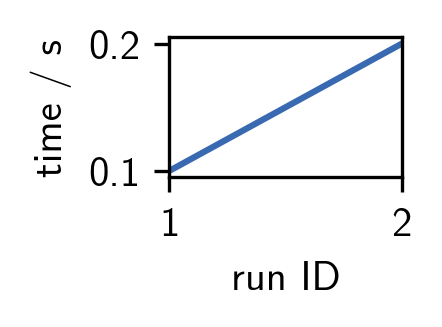

In [18]:
fig, ax = plt.subplots(figsize=(1, 1/1.618))
helper.plot_timings(sleep_timings, ax=ax, id_to_x=lambda x: int(x))

### CommonNN Clustering

In [13]:
report_dir = pathlib.Path("reports/qcm07/cnnclustering_fit")

Clustering of a data sets with increasing number of points while dimensionality, cluster parameters, and cluster recipe are fixed:

  - Default recipe:
    - $d = 2$, $r = 0.25$, $c = 0$ :   (run_a_a)
    
  - Distance recipe:
    - $d = 2$, $r = 0.25$, $c = 0$ :   (run_b_a)

  - Neighbours recipe:
    - $d = 2$, $r = 0.25$, $c = 0$ :   (run_c_a)
    
  - Neighbours sorted recipe:
    - $d = 2$, $r = 0.25$, $c = 0$ :   (run_d_a)
    - $d = 2$, $r = 0.25$, $c = 50$ :  (run_d_b)
    - $d = 2$, $r = 0.25$, $c = 100$ : (run_d_c)
    - $d = 2$, $r = 0.1$, $c = 0$ :    (run_d_d)
    - $d = 2$, $r = 0.1$, $c = 50$ :   (run_d_e)
    - $d = 2$, $r = 0.1$, $c = 100$ :  (run_d_f)

#### Data set: no structure

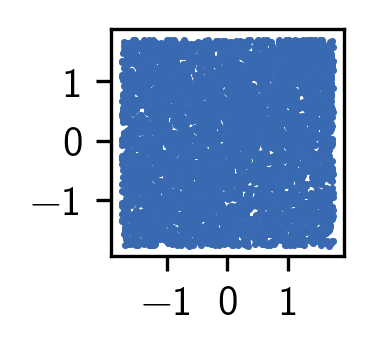

In [15]:
# The test data
fig, ax = plt.subplots(figsize=(1, 1))
ax.scatter(
    *helper_base.gen_no_structure_points((5000, 2)).T,
    s=0.5,
)

In [16]:
if "RUN_ARGUMENTS_MAP" not in dir():
    RUN_ARGUMENTS_MAP = {}

if "RUN_TIMINGS_MAP" not in dir():
    RUN_TIMINGS_MAP = {}

if "RUN_SCALING_MAP" not in dir():
    RUN_SCALING_MAP = {}

In [35]:
run_name_list = [
    'no_structure_run_a_a',
    'no_structure_run_b_a',
    'no_structure_run_c_a',
    'no_structure_run_d_a',
    'no_structure_run_d_a',
    'no_structure_run_d_b',
    'no_structure_run_d_c',
    'no_structure_run_d_d',
    'no_structure_run_d_e',
    'no_structure_run_d_f',
]

for run_name in run_name_list:    
    report_file = report_dir / f"{run_name}.json"
    
    if not report_file.is_file():
        continue

    RUN_TIMINGS_MAP[run_name] = helper.load_report(report_file)

In [17]:
RUN_TIMINGS_MAP

{}

In [18]:
n_points_list = [500 * 2**x for x in range(10)]

runs = [
    (   # run_name, case_name
        "no_structure", "a_a",
        helper_base.gen_no_structure_points,   # gen_func
        None,                                  # transform_func
        cases.setup_commonnn_clustering__fit,  # setup_func
        n_points_list                          # n_list
    )
]

In [22]:
for run_name, case_name, gen_func, transform_func, setup_func, n_list in runs:
    full_run_name = f"{run_name}_run_{case_name}"
    report_file = report_dir / f"{full_run_name}_raw.json"

    cases.choose_case(case_name)(RUN_ARGUMENTS_MAP, full_run_name, n_list)
    RUN_TIMINGS_MAP[full_run_name] = {}

    print(f"Collection for run: {full_run_name}")
    collect_timings(
        gen_func,
        setup_func,
        RUN_ARGUMENTS_MAP[full_run_name],
        transform_func=transform_func,
        timings=RUN_TIMINGS_MAP[full_run_name]
    )
    
    helper_jupyter.save_report(RUN_TIMINGS_MAP[full_run_name], report_file, overwrite=True)
    
    helper_jupyter.print_ratios(helper_jupyter.get_ratios(RUN_TIMINGS_MAP[full_run_name]))

Collection for run: no_structure_run_a_a


Run completed:   0%|          | 0/2 [00:00<?, ?it/s]

Timed run ID:        500    (07.07.2021 16:53:25)
Timed run ID:       1000    (07.07.2021 16:53:25)
    Run ID: Factor
       500: 1.00
      1000: 3.39


<a id="run_b"></a>
#### Run b

In [ ]:
run_name = "no_structure_run_b"
report_file = report_dir / f"{run_name}.json"

gen_func = helper.gen_no_structure_points
transform_func = pairwise_distances
setup_func = setup_commonnn_clustering__fit

In [ ]:
radius_cutoff = 0.25
cnn_cutoff = 0

RUN_ARGUMENTS_MAP[run_name] = []
for n_points in [500 * 2**x for x in range(8)]:  # Memory error on 128000
    RUN_ARGUMENTS_MAP[run_name].append(
        {
            "id": str(n_points),
            "gen": (
                ((n_points, 2),), {}
            ),
            "setup": (
                (), {"recipe": distance_recipe}
            ),
            "timed": (
                (_types.ClusterParameters(radius_cutoff, cnn_cutoff),), {}
            ),
        }
    )

In [ ]:
print(f"Collection for run: {run_name}")
RUN_TIMINGS_MAP[run_name] = {}
collect_timings(
    gen_func,
    setup_func,
    RUN_ARGUMENTS_MAP[run_name],
    transform_func=transform_func,
    timings=RUN_TIMINGS_MAP[run_name]
)

In [ ]:
RUN_TIMINGS_MAP[run_name]["128000"] = "MemoryError"

In [ ]:
helper.save_report(RUN_TIMINGS_MAP[run_name], report_file, overwrite=True)

In [ ]:
helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[run_name], which="best"))

<a id="run_c"></a>
#### Run c

In [ ]:
run_name = "no_structure_run_c"
report_file = report_dir / f"{run_name}.json"

gen_func = helper.gen_no_structure_points
transform_func = compute_neighbours
setup_func = setup_commonnn_clustering__fit

In [ ]:
RUN_ARGUMENTS_MAP[run_name] = []

radius_cutoff = 0.25
cnn_cutoff = 0
for n_points in n_points_list:
    RUN_ARGUMENTS_MAP[run_name].append(
        {
            "id": str(n_points),
            "gen": (
                ((n_points, 2),), {}
            ),
            "transform": (
                (radius_cutoff,), {}
            ),
            "setup": (
                (), {
                    "preparation_hook": hooks.prepare_neighbourhoods,
                    "recipe": neighbours_recipe
                    }
            ),
            "timed": (
                (_types.ClusterParameters(radius_cutoff, cnn_cutoff),), {}
            ),
        }
    )

In [ ]:
print(f"Collection for run: {run_name}")
RUN_TIMINGS_MAP[run_name] = {}
collect_timings(
    gen_func,
    setup_func,
    RUN_ARGUMENTS_MAP[run_name],
    transform_func=transform_func,
    timings=RUN_TIMINGS_MAP[run_name]
)

In [ ]:
helper.save_report(RUN_TIMINGS_MAP[run_name], report_file, overwrite=True)

In [ ]:
helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[run_name], which="best"))

<a id="run_d_a"></a>
#### Run d a

In [ ]:
run_name = "no_structure_run_d_a"
report_file = report_dir / f"{run_name}.json"

gen_func = helper.gen_no_structure_points
transform_func = compute_neighbours
setup_func = setup_commonnn_clustering__fit

In [ ]:
RUN_ARGUMENTS_MAP[run_name] = []

radius_cutoff = 0.25
cnn_cutoff = 0
for n_points in n_points_list:
    RUN_ARGUMENTS_MAP[run_name].append(
        {
            "id": str(n_points),
            "gen": (
                ((n_points, 2),), {}
            ),
            "transform": (
                (radius_cutoff,), {"sort": True}
            ),
            "setup": (
                (), {
                    "preparation_hook": hooks.prepare_neighbourhoods,
                    "recipe": neighbours_sorted_recipe
                    }
            ),
            "timed": (
                (_types.ClusterParameters(radius_cutoff, cnn_cutoff),), {}
            ),
        }
    )

In [ ]:
print(f"Collection for run: {run_name}")
RUN_TIMINGS_MAP[run_name] = {}
collect_timings(
    gen_func,
    setup_func,
    RUN_ARGUMENTS_MAP[run_name],
    transform_func=transform_func,
    timings=RUN_TIMINGS_MAP[run_name]
)

In [ ]:
helper.save_report(RUN_TIMINGS_MAP[run_name], report_file, overwrite=True)

In [ ]:
helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[run_name], which="best"))

<a id="run_d_b"></a>
#### Run d b

In [ ]:
run_name = "no_structure_run_d_b"
report_file = report_dir / f"{run_name}.json"

gen_func = helper.gen_no_structure_points
transform_func = compute_neighbours
setup_func = setup_commonnn_clustering__fit

In [ ]:
RUN_ARGUMENTS_MAP[run_name] = []

radius_cutoff = 0.25
cnn_cutoff = 50
for n_points in n_points_list:
    RUN_ARGUMENTS_MAP[run_name].append(
        {
            "id": str(n_points),
            "gen": (
                ((n_points, 2),), {}
            ),
            "transform": (
                (radius_cutoff,), {"sort": True}
            ),
            "setup": (
                (), {
                    "preparation_hook": hooks.prepare_neighbourhoods,
                    "recipe": neighbours_sorted_recipe
                    }
            ),
            "timed": (
                (_types.ClusterParameters(radius_cutoff, cnn_cutoff),), {}
            ),
        }
    )

In [ ]:
print(f"Collection for run: {run_name}")
RUN_TIMINGS_MAP[run_name] = {}
collect_timings(
    gen_func,
    setup_func,
    RUN_ARGUMENTS_MAP[run_name],
    transform_func=transform_func,
    timings=RUN_TIMINGS_MAP[run_name]
)

In [ ]:
helper.save_report(RUN_TIMINGS_MAP[run_name], report_file, overwrite=True)

In [ ]:
helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[run_name], which="best"))

<a id="run_d_c"></a>
#### Run d c

In [ ]:
run_name = "no_structure_run_d_c"
report_file = report_dir / f"{run_name}.json"

gen_func = helper.gen_no_structure_points
transform_func = compute_neighbours
setup_func = setup_commonnn_clustering__fit

In [ ]:
RUN_ARGUMENTS_MAP[run_name] = []

radius_cutoff = 0.25
cnn_cutoff = 100
for n_points in n_points_list:
    RUN_ARGUMENTS_MAP[run_name].append(
        {
            "id": str(n_points),
            "gen": (
                ((n_points, 2),), {}
            ),
            "transform": (
                (radius_cutoff,), {"sort": True}
            ),
            "setup": (
                (), {
                    "preparation_hook": hooks.prepare_neighbourhoods,
                    "recipe": neighbours_sorted_recipe
                    }
            ),
            "timed": (
                (_types.ClusterParameters(radius_cutoff, cnn_cutoff),), {}
            ),
        }
    )

In [ ]:
print(f"Collection for run: {run_name}")
RUN_TIMINGS_MAP[run_name] = {}
collect_timings(
    gen_func,
    setup_func,
    RUN_ARGUMENTS_MAP[run_name],
    transform_func=transform_func,
    timings=RUN_TIMINGS_MAP[run_name]
)

In [ ]:
helper.save_report(RUN_TIMINGS_MAP[run_name], report_file, overwrite=True)

In [ ]:
helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[run_name], which="best"))

<a id="run_d_d"></a>
#### Run d d

In [ ]:
run_name = "no_structure_run_d_d"
report_file = report_dir / f"{run_name}.json"

gen_func = helper.gen_no_structure_points
transform_func = compute_neighbours
setup_func = setup_commonnn_clustering__fit

In [ ]:
RUN_ARGUMENTS_MAP[run_name] = []

radius_cutoff = 0.1
cnn_cutoff = 0
for n_points in n_points_list:
    RUN_ARGUMENTS_MAP[run_name].append(
        {
            "id": str(n_points),
            "gen": (
                ((n_points, 2),), {}
            ),
            "transform": (
                (radius_cutoff,), {"sort": True}
            ),
            "setup": (
                (), {
                    "preparation_hook": hooks.prepare_neighbourhoods,
                    "recipe": neighbours_sorted_recipe
                    }
            ),
            "timed": (
                (_types.ClusterParameters(radius_cutoff, cnn_cutoff),), {}
            ),
        }
    )

In [ ]:
print(f"Collection for run: {run_name}")
RUN_TIMINGS_MAP[run_name] = {}
collect_timings(
    gen_func,
    setup_func,
    RUN_ARGUMENTS_MAP[run_name],
    transform_func=transform_func,
    timings=RUN_TIMINGS_MAP[run_name]
)

In [ ]:
helper.save_report(RUN_TIMINGS_MAP[run_name], report_file, overwrite=True)

In [ ]:
helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[run_name], which="best"))

<a id="run_d_e"></a>
#### Run d e

In [ ]:
run_name = "no_structure_run_d_e"
report_file = report_dir / f"{run_name}.json"

gen_func = helper.gen_no_structure_points
transform_func = compute_neighbours
setup_func = setup_commonnn_clustering__fit

In [ ]:
RUN_ARGUMENTS_MAP[run_name] = []

radius_cutoff = 0.1
cnn_cutoff = 50
for n_points in n_points_list:
    RUN_ARGUMENTS_MAP[run_name].append(
        {
            "id": str(n_points),
            "gen": (
                ((n_points, 2),), {}
            ),
            "transform": (
                (radius_cutoff,), {"sort": True}
            ),
            "setup": (
                (), {
                    "preparation_hook": hooks.prepare_neighbourhoods,
                    "recipe": neighbours_sorted_recipe
                    }
            ),
            "timed": (
                (_types.ClusterParameters(radius_cutoff, cnn_cutoff),), {}
            ),
        }
    )

In [ ]:
print(f"Collection for run: {run_name}")
RUN_TIMINGS_MAP[run_name] = {}
collect_timings(
    gen_func,
    setup_func,
    RUN_ARGUMENTS_MAP[run_name],
    transform_func=transform_func,
    timings=RUN_TIMINGS_MAP[run_name]
)

In [ ]:
helper.save_report(RUN_TIMINGS_MAP[run_name], report_file, overwrite=True)

In [ ]:
helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[run_name], which="best"))

<a id="run_d_f"></a>
#### Run d f

In [ ]:
run_name = "no_structure_run_d_f"
report_file = report_dir / f"{run_name}.json"

gen_func = helper.gen_no_structure_points
transform_func = compute_neighbours
setup_func = setup_commonnn_clustering__fit

In [ ]:
RUN_ARGUMENTS_MAP[run_name] = []

radius_cutoff = 0.1
cnn_cutoff = 100
for n_points in n_points_list:
    RUN_ARGUMENTS_MAP[run_name].append(
        {
            "id": str(n_points),
            "gen": (
                ((n_points, 2),), {}
            ),
            "transform": (
                (radius_cutoff,), {"sort": True}
            ),
            "setup": (
                (), {
                    "preparation_hook": hooks.prepare_neighbourhoods,
                    "recipe": neighbours_sorted_recipe
                    }
            ),
            "timed": (
                (_types.ClusterParameters(radius_cutoff, cnn_cutoff),), {}
            ),
        }
    )

In [ ]:
print(f"Collection for run: {run_name}")
RUN_TIMINGS_MAP[run_name] = {}
collect_timings(
    gen_func,
    setup_func,
    RUN_ARGUMENTS_MAP[run_name],
    transform_func=transform_func,
    timings=RUN_TIMINGS_MAP[run_name]
)

In [ ]:
helper.save_report(RUN_TIMINGS_MAP[run_name], report_file, overwrite=True)

In [ ]:
helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[run_name], which="best"))

### CommonNN Clustering - complete

In [21]:
report_dir = pathlib.Path("reports/qcm07/cnnclustering_fit")

Clustering of a 2D toy data set (varied blobs) with increasing number of points while dimensionality, cluster parameters, and cluster recipe are fixed. This benchmark includes timings for preparation steps:

  - Neighbours sorted recipe:
    - $d = 2$, $r = 0.2$, $c = 0$ :  [run d a](#run_d_a)
    - $d = 2$, $r = 0.2$, $c = 50$ :  [run d b](#run_d_b)
    - $d = 2$, $r = 0.2$, $c = 100$ :  [run d c](#run_d_c)
    - $d = 2$, $r = 0.1$, $c = 0$ :  [run d d](#run_d_d)
    - $d = 2$, $r = 0.1$, $c = 50$ :  [run d e](#run_d_e)
    - $d = 2$, $r = 0.1$, $c = 100$ :  [run d f](#run_d_f)

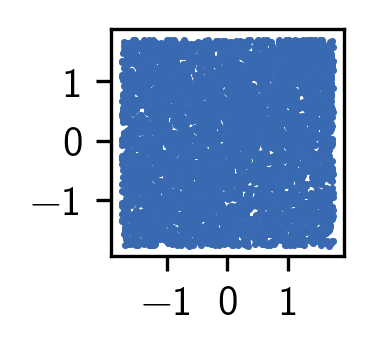

In [28]:
# The test data
fig, ax = plt.subplots(figsize=(1, 1))
ax.scatter(
    *helper.gen_blobs_points((5000, 2)).T,
    s=0.5,
)

In [23]:
n_points_list = [500 * 2**x for x in range(10)]

In [24]:
n_points_list

[500, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 128000, 256000]

## Scaling

Fit for empirical growth function:

$ t = a n^b + c$

In [39]:
mask_map = {
    "no_structure_run_d_e": {"500", "32000"},
    "no_structure_run_d_f": {"500", "64000"}
}

for full_run_name, timings in RUN_TIMINGS_MAP.items():
    print(full_run_name)
    x, y = zip(
        *(
            (int(k), v.best)
            for k, v in timings.items()
            if (isinstance(v, helper.TimeitResult)) & (k not in mask_map.get(full_run_name, set()))
            )
        )
    x = np.asarray(x)
    y = np.asarray(y)
    sorti = np.argsort(x)
    x = x[sorti]
    y = y[sorti]
    
    newx = np.linspace(n_points_list[0], n_points_list[-1], 100)
    fity, (popt, perr) = helper.scale(x, y, newx)
    RUN_SCALING_MAP[full_run_name] = (newx, fity), (popt[1], perr[1])

no_structure_run_a
no_structure_run_b
no_structure_run_c
no_structure_run_d_a
no_structure_run_d_b
no_structure_run_d_c
no_structure_run_d_d
no_structure_run_d_e
no_structure_run_d_f


## Plots

In [143]:
figsrc_dir = pathlib.Path(os.path.expandvars("$WD/CommonNN/Manuscript/figsrc/Benchmark"))

### Compare parameters for screen

In [153]:
run_name_list = [
    ("no_structure_run_d_a", f"$r=0.25, c=0$"),
    ("no_structure_run_d_b", f"$r=0.25, c=50$"),
    ("no_structure_run_d_c", f"$r=0.25, c=100$"),
]

Text(0, 0.5, 'time / s')

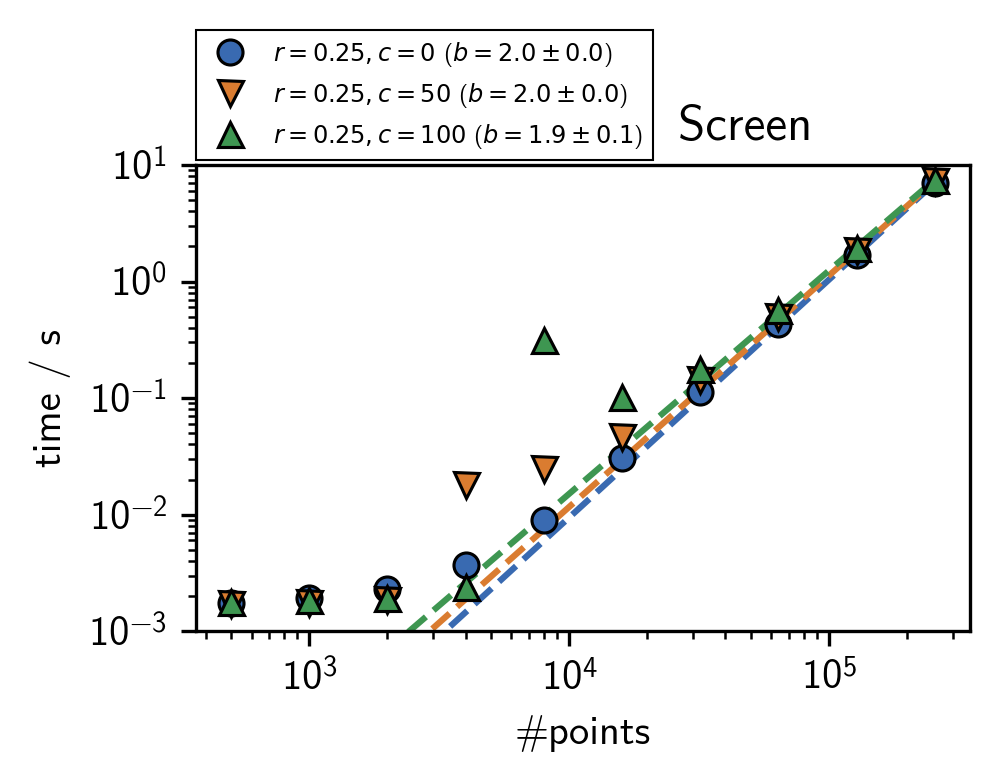

In [154]:
plt.close("all")
fig, log_ax = plt.subplots(figsize=(3.33, 3.33 / 1.618))
log_ax.set_prop_cycle(
    marker=marker_list,
    color=color_list,
)
_ = evaluate_timings(
    RUN_TIMINGS_MAP, RUN_SCALING_MAP, run_name_list,
    log_ax=log_ax,
    plot_props={
        "linestyle": "",
        "markeredgecolor": "k",
        "markeredgewidth": 0.75,
        },
    legend_props={
        "loc": (0, 1.01)
        }
    )

log_ax.set_ylim(1e-3, 10)

log_ax.set_title(" " * 20 + "Screen")
log_ax.set_xlabel("#points")
log_ax.set_ylabel("time / s")

In [166]:
run_name_list = [
    ("no_structure_run_d_b", f"$r=0.25, c=50$"),
    ("no_structure_run_d_c", f"$r=0.25, c=100$"),
    ("no_structure_run_d_e", f"$r=0.10, c=50$"),
    ("no_structure_run_d_f", f"$r=0.10, c=100$"),
]

Text(0, 0.5, 'time / s')

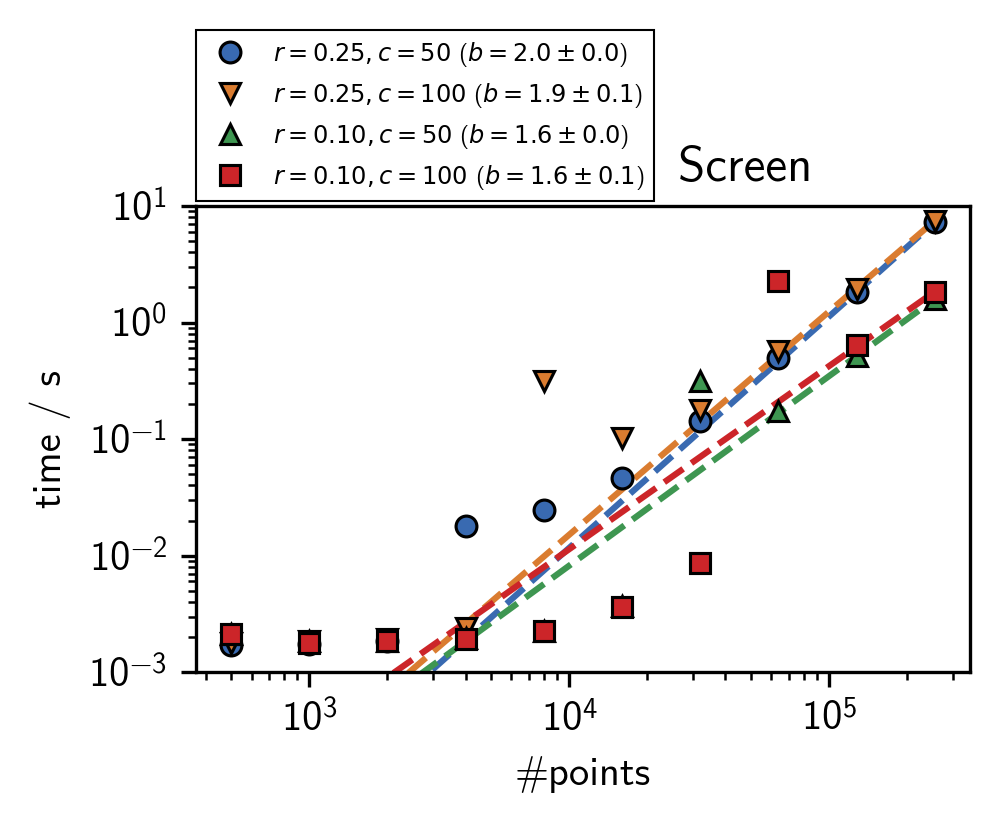

In [167]:
plt.close("all")
fig, log_ax = plt.subplots(figsize=(3.33, 3.33 / 1.618))
log_ax.set_prop_cycle(
    marker=marker_list,
    color=color_list,
)
_ = evaluate_timings(
    RUN_TIMINGS_MAP, RUN_SCALING_MAP, run_name_list,
    log_ax=log_ax,
    plot_props={
        "linestyle": "",
        "markeredgecolor": "k",
        "markeredgewidth": 0.75,
        "markersize": 5
        },
    legend_props={
        "loc": (0, 1.01)
        }
    )

log_ax.set_ylim(1e-3, 10)

log_ax.set_title(" " * 20 + "Screen")
log_ax.set_xlabel("#points")
log_ax.set_ylabel("time / s")

### Compare input variations

In [40]:
run_name_list = [
    ("no_structure_run_a", f"points $r=0.25, c=0$"),
    ("no_structure_run_b", f"distances $r=0.25, c=0$"),
    ("no_structure_run_c", f"neighbourhoods $r=0.25, c=0$"),
    ("no_structure_run_d_a", f"neigh. sorted $r=0.25, c=0$"),
    ("no_structure_run_d_d", f"neigh. sorted $r=0.10, c=0$"),
]

Text(0, 0.5, 'time / s')

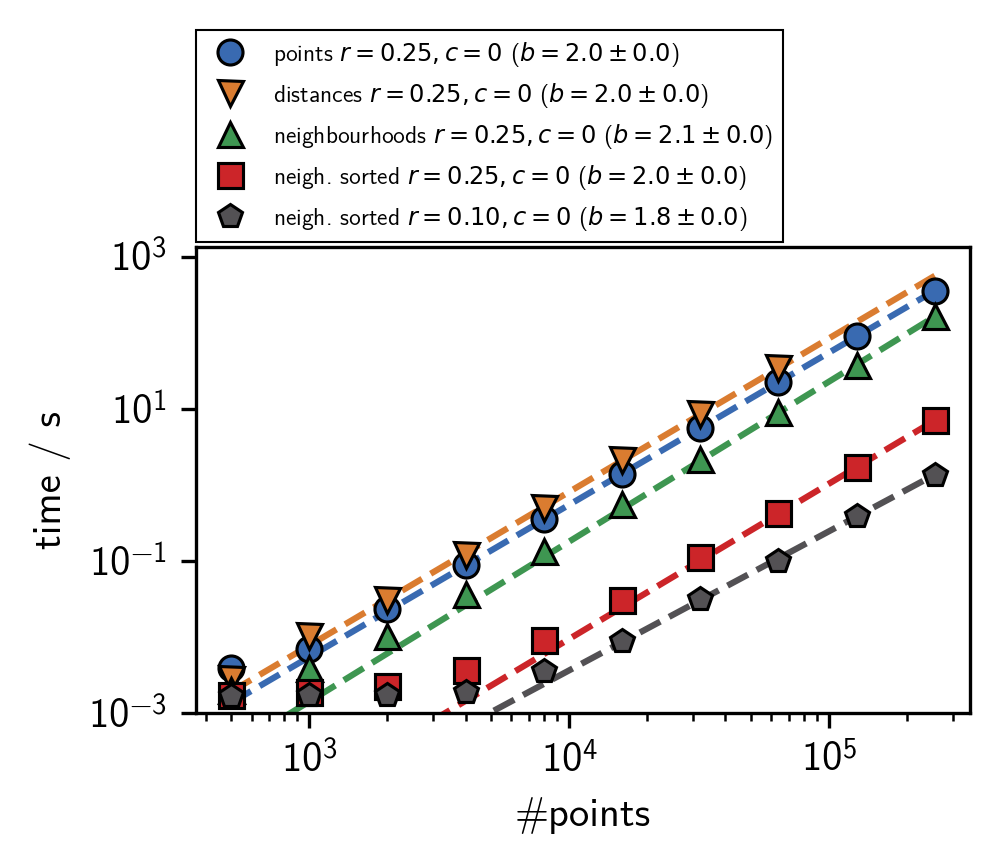

In [41]:
plt.close("all")
fig, log_ax = plt.subplots(figsize=(3.33, 3.33 / 1.618))
log_ax.set_prop_cycle(
    marker=marker_list,
    color=color_list,
)
_ = evaluate_timings(
    RUN_TIMINGS_MAP, RUN_SCALING_MAP, run_name_list,
    log_ax=log_ax,
    plot_props={
        "linestyle": "",
        "markeredgecolor": "k",
        "markeredgewidth": 0.75,
        },
    legend_props={
        "loc": (0, 1.01)
        }
    )

log_ax.set_ylim(1e-3, None)

log_ax.set_title(" " * 20 + "")
log_ax.set_xlabel("#points")
log_ax.set_ylabel("time / s")

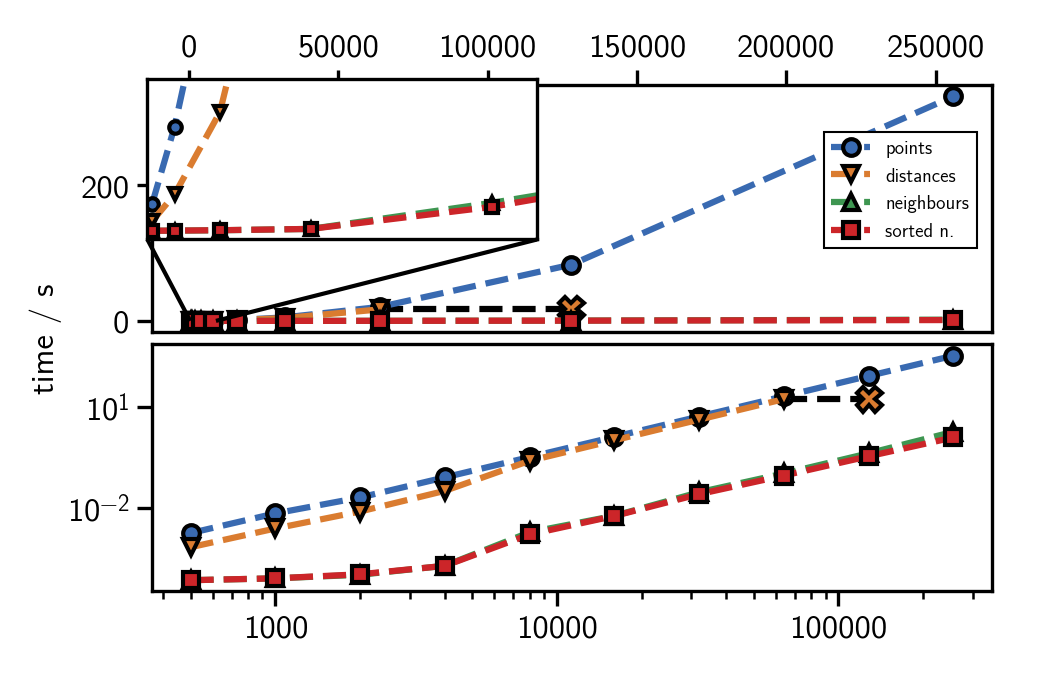

In [81]:
mpl.rcParams["font.size"] = 8
mpl.rcParams["axes.labelpad"] = 2
mpl.rcParams["xtick.major.pad"] = 2
mpl.rcParams["xtick.minor.pad"] = 1.9
mpl.rcParams["ytick.major.pad"] = 2
mpl.rcParams["ytick.minor.pad"] = 1.9

fig, (normal_ax, log_ax) = plt.subplots(2, 1, figsize=(3.33, 3.33/1.618))

run_name_list = [
    ('no_structure_run_a', 'points'),
    ('no_structure_run_b', 'distances'),
    ('no_structure_run_c', 'neighbours'),
    ('no_structure_run_d', 'sorted n.'),
]
markers = iter(["o", "v", "^", "s", "p", "P", "*", "h", "d"])

normal_ax.set_position([0.13, 0.51, 0.84, 0.40])
log_ax.set_position([0.13, 0.09, 0.84, 0.40])

# Inset
inset_ax = fig.add_axes(
    [0.125, 0.66, 0.39, 0.26],
    zorder=3,
    )

for name, label in run_name_list:
    marker = next(markers)
    
    plot_timings(
        RUN_TIMINGS_MAP[name],
        ax=normal_ax,
        id_to_x=lambda x: int(x),
        sort_ids=True,
        set_ax_props=False,
        plot_props={
            "label": label,
            "marker": marker,
            "markersize": 4
        }
    )
    
    line = normal_ax.lines[-1]
    log_line, = log_ax.plot(*line.get_xydata().T)
    saved_transform = log_line.get_transform()
    saved_clipbox = log_line.clipbox
    log_line.update_from(line)
    log_line.set_transform(saved_transform)
    log_line.clipbox = saved_clipbox
    
    line = normal_ax.lines[-1]
    inset_line, = inset_ax.plot(*line.get_xydata().T)
    saved_transform = inset_line.get_transform()
    saved_clipbox = inset_line.clipbox
    inset_line.update_from(line)
    inset_line.set_transform(saved_transform)
    inset_line.clipbox = saved_clipbox
    
    inset_line.set_markersize(3)
    
normal_ax.xaxis.tick_top()

normal_ax.set(**{
    "xlabel": None,
    "xlabel": None
})

log_ax.set(**{
    "xlabel": None,
    "xlabel": None,
    "xscale": "log",
    "yscale": "log",
})

inset_ax.set(**{
    "xlim": (400, 9000),
    "ylim": (-0.0005, 0.01),
    "xticks": (),
    "yticks": (),
})

mark_inset(normal_ax, inset_ax, loc1=3, loc2=4, edgecolor="k")

# Annotate memory error
annotate_memory_error(
    ax=normal_ax, line=normal_ax.get_lines()[1],
    memory_error_id=128000
)
annotate_memory_error(
    ax=log_ax, line=log_ax.get_lines()[1],
    memory_error_id=128000
)
    
commonax = fig.add_axes(
    [0.04, 0., 0.97, 1],
    zorder=-1,
    frame_on=False
    )

commonax.set(**{
    "xticks": (),
    "yticks": ()
})
commonax.set_ylabel("time / s", labelpad=0)

# Legend
legend = normal_ax.legend(
    fancybox=False,
    framealpha=1,
    edgecolor="k",
    fontsize="xx-small",
    loc=(0.80, 0.34)
    )
legend.get_frame().set_linewidth(0.5)

log_ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# fig.subplots_adjust(left=0.11, bottom=0.1, right=0.86, top=0.89, hspace=0.1)
fig.savefig(figsrc_dir / "bm_cnnclustering_fit_no_structure_a_b_c_d.png")

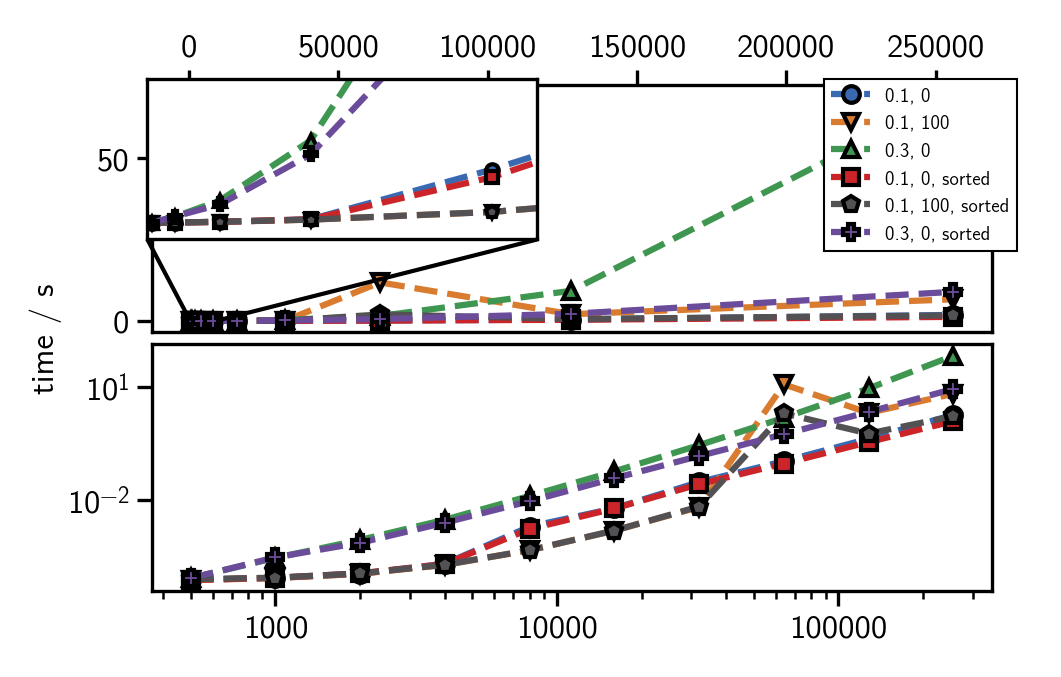

In [80]:
mpl.rcParams["font.size"] = 8
mpl.rcParams["axes.labelpad"] = 2
mpl.rcParams["xtick.major.pad"] = 2
mpl.rcParams["xtick.minor.pad"] = 1.9
mpl.rcParams["ytick.major.pad"] = 2
mpl.rcParams["ytick.minor.pad"] = 1.9

fig, (normal_ax, log_ax) = plt.subplots(2, 1, figsize=(3.33, 3.33/1.618))

run_name_list = [
    ('no_structure_run_c', '0.1, 0'),
    ('no_structure_run_c_b', '0.1, 100'),
    ('no_structure_run_c_c', '0.3, 0'),
    ('no_structure_run_d', '0.1, 0, sorted'),
    ('no_structure_run_d_b', '0.1, 100, sorted'),
    ('no_structure_run_d_c', '0.3, 0, sorted'),
]
markers = iter(["o", "v", "^", "s", "p", "P", "*", "h", "d"])

normal_ax.set_position([0.13, 0.51, 0.84, 0.40])
log_ax.set_position([0.13, 0.09, 0.84, 0.40])

# Inset
inset_ax = fig.add_axes(
    [0.125, 0.66, 0.39, 0.26],
    zorder=3,
    )

for name, label in run_name_list:
    marker = next(markers)
    
    plot_timings(
        RUN_TIMINGS_MAP[name],
        ax=normal_ax,
        id_to_x=lambda x: int(x),
        sort_ids=True,
        set_ax_props=False,
        plot_props={
            "label": label,
            "marker": marker,
            "markersize": 4
        }
    )
    
    line = normal_ax.lines[-1]
    log_line, = log_ax.plot(*line.get_xydata().T)
    saved_transform = log_line.get_transform()
    saved_clipbox = log_line.clipbox
    log_line.update_from(line)
    log_line.set_transform(saved_transform)
    log_line.clipbox = saved_clipbox
    
    line = normal_ax.lines[-1]
    inset_line, = inset_ax.plot(*line.get_xydata().T)
    saved_transform = inset_line.get_transform()
    saved_clipbox = inset_line.clipbox
    inset_line.update_from(line)
    inset_line.set_transform(saved_transform)
    inset_line.clipbox = saved_clipbox
    
    inset_line.set_markersize(3)
    
normal_ax.xaxis.tick_top()

normal_ax.set(**{
    "xlabel": None,
    "xlabel": None
})

log_ax.set(**{
    "xlabel": None,
    "xlabel": None,
    "xscale": "log",
    "yscale": "log",
})

inset_ax.set(**{
    "xlim": (400, 9000),
    "ylim": (-0.0005, 0.005),
    "xticks": (),
    "yticks": (),
})

mark_inset(normal_ax, inset_ax, loc1=3, loc2=4, edgecolor="k")
    
commonax = fig.add_axes(
    [0.04, 0., 0.97, 1],
    zorder=-1,
    frame_on=False
    )

commonax.set(**{
    "xticks": (),
    "yticks": ()
})
commonax.set_ylabel("time / s", labelpad=0)

# Legend
legend = normal_ax.legend(
    fancybox=False,
    framealpha=1,
    edgecolor="k",
    fontsize="xx-small",
    loc=(0.8, 0.33)
    )
legend.get_frame().set_linewidth(0.5)

log_ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# fig.subplots_adjust(left=0.11, bottom=0.1, right=0.86, top=0.89, hspace=0.1)
fig.savefig(figsrc_dir / "bm_cnnclustering_fit_no_structure_c_cb_cc_d_db_dc.png")